In [1]:
import pandas as pd 
import numpy as np
from src.download import *
import zipfile 
import glob
from tqdm import tqdm  
import os
from src.fasta import FASTAFile
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score, completeness_score
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import re
import subprocess
import math 
from utils import * 

%load_ext autoreload
%autoreload 2

niks_domain = '[XNGDRYS]IK[SDLT]'
ycf_domain = 'Y.C...F'

In [2]:
genome_metadata_df = pd.read_csv('../data/ar53_metadata_r226.tsv', sep='\t')
genome_metadata_df.accession = [genome_id.replace('RS_','').replace('GB_', '') for genome_id in genome_metadata_df.accession]
genome_metadata_df = genome_metadata_df[genome_metadata_df.checkm_completeness > 0.8].copy()

kivenson_genome_ids = pd.read_csv('../data/kivenson_2023_table_2.csv')['Assembly Accession'].tolist() # Get the genomes reported to have Pyl machinery. 
kivenson_genome_ids += [genome_id.replace('GCA', 'GCF') for genome_id in kivenson_genome_ids]

# For some reason, there are genome IDs in SI Table 5 which are not in the SI Table 2 list, so had to add them seperately. 
table_5_metadata_df = pd.read_csv('../data/kivenson_2023_table_5.csv')
table_5_metadata_df['accession'] = ['_'.join(file_name.split('_')[:2]) for file_name in table_5_metadata_df['Filename']]
table_5_metadata_df = table_5_metadata_df.set_index('accession')

kivenson_genome_ids += table_5_metadata_df.index.tolist()
kivenson_genome_ids = list(set(kivenson_genome_ids)) # Remove duplicates.

rep_genome_ids = genome_metadata_df.gtdb_genome_representative.unique()
rep_genome_ids = [genome_id.replace('RS_','').replace('GB_', '') for genome_id in rep_genome_ids]

# downloader = NCBI()
# downloader.get_genomes(kivenson_genome_ids + rep_genome_ids)
# extract()

downloaded_genome_ids = [file_name.replace('.fa', '') for file_name in os.listdir('../data/ncbi/proteins/')]
genome_metadata_df = genome_metadata_df[genome_metadata_df.accession.isin(downloaded_genome_ids)]
genome_metadata_df = genome_metadata_df.set_index('accession')


In [3]:
genome_id_numbers = os.listdir('../data/ncbi/genomes/')
genome_id_numbers = [re.search(r'\d{2,}', genome_id).group(0) for genome_id in genome_id_numbers]
print('Num. genome ID numbers:', len(genome_id_numbers))
print('Num. unique genome ID numbers:', len(set(genome_id_numbers)))

Num. genome ID numbers: 7442
Num. unique genome ID numbers: 7237


In [4]:
# for path in tqdm(glob.glob('../data/ncbi/genomes/*'), 'Running Prodigal with default code on Archaeal genomes.'):
#     output_path = os.path.basename(path).replace('.fn', '.fa')
#     output_path = os.path.join('../data/prodigal', output_path)
#     if not os.path.exists(output_path):
#         subprocess.run(f'prodigal -i {path} -a {output_path}', shell=True, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# for path in tqdm(glob.glob('../data/prodigal/*'), 'Running HMM search on Prodigal outputs.'):
#     output_path = os.path.basename(path).replace('.fa', '.tab')
#     output_path = os.path.join('../data/hmmer', output_path)
#     if not os.path.exists(output_path):
#         try:
#             subprocess.run(f'hmmsearch --domtblout {output_path} ../data/query.hmm {path}', shell=True, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
#         except:
#             print(f'HMM search failed for {path}')

In [5]:
# def get_arf1(path:str):
#     df = FASTAFile(path).to_df()
#     df = df[df.description.str.contains('aRF-1')].copy()
#     df['genome_id'] = os.path.basename(path).replace('.fa', '')
#     return df 

# # Why doesn't every genome have a release factors?
# if not os.path.exists('../data/arf1.csv'):
#     arf1_df = [get_arf1(path) for path in tqdm(glob.glob('../data/ncbi/proteins/*'), desc='Collecting aRF-1 data.')]
#     arf1_df = pd.concat(arf1_df)
#     arf1_df.to_csv('../data/arf1.csv')
# else:
#     arf1_df = pd.read_csv('../data/arf1.csv', index_col=0)

# arf1_df = arf1_df[~arf1_df.index.duplicated()].copy() # Drop duplicate indices.
# genome_metadata_df['arf1'] = genome_metadata_df.index.isin(arf1_df.genome_id)

# arf1_df['pyl'] = arf1_df.genome_id.map(genome_metadata_df.pyl)
# arf1_df['category_1'] = arf1_df.genome_id.map(genome_metadata_df.category_1)
# arf1_df['length'] = arf1_df.seq.apply(len)

In [6]:
# Is there a new genetic code? Or is there still flexible recoding, to varying degrees?
# Perhaps has some kind of stem-loopy thing that encourages incoproration when a truncated protein would be really bad?

# Development of a stop codon right after the UAG in a bunch of proteins suggests that Pyl incorporation might be generally 
# favored. Is its random widespread addition in a bunch of unrelated proteins actually just random? Or is there some regulatory role?
# Does it replace an uncommon codon? Potential for multiple gene products?

In [ ]:
if not os.path.exists('../data/hmmer.csv'):
    hmmer_df = hmmer_load()
    hmmer_df.to_csv('../data/hmmer.csv')
else:
    hmmer_df = pd.read_csv('../data/hmmer.csv')

# Based on the Kivenson et. al. paper, they count any organism with at least two of the Pyl genes as Pyl-utilizing. 
# I might just do one?
hmmer_df = hmmer_df[hmmer_df.e_value < 1e-5].copy()

pyl_genome_ids = hmmer_df[hmmer_df.query_name.str.contains('Pyl')].genome_id.unique()
no_pyl_genome_ids = hmmer_df[~hmmer_df.genome_id.isin(pyl_genome_ids)].genome_id.unique()

print('Num. genomes:', hmmer_df.genome_id.nunique())
print('Num. genomes with Pyl machinery:', len(pyl_genome_ids))

# shared_genome_ids = np.intersect1d(hmmer_df.genome_id.unique(), kivenson_genome_ids)
# assert np.all(np.isin(shared_genome_ids, pyl_genome_ids)), 'Some of the genomes marked as Pyl-containing are not marked as Pyl-containing in the Kivenson paper.'

hmmer_load:   2%|▏         | 180/7441 [00:07<03:48, 31.73it/s]

hmmer_load: Failed to load HMMer results for ../data/hmmer/GCA_018302685.1.tab.


hmmer_load:  67%|██████▋   | 5019/7441 [03:35<01:24, 28.54it/s]

hmmer_load: Failed to load HMMer results for ../data/hmmer/GCA_030699005.1.tab.


hmmer_load:  78%|███████▊  | 5787/7441 [04:07<01:08, 24.12it/s]

hmmer_load: Failed to load HMMer results for ../data/hmmer/GCA_030699455.1.tab.


hmmer_load: 100%|██████████| 7441/7441 [05:17<00:00, 23.43it/s]


Num. genomes: 7401
Num. genomes with Pyl machinery: 6156


In [9]:
hmmer_df

,target_name,query_name,e_value,query_coords,target_coords,envelope_coords,target_length,query_length,n_hits,genome_id
0,JACAFT010000008.1_31,aRF1_eRF1,5.700000e-138,2..403,10..415,9..415,417,403,1,GCA_013378375.1
2,JACAFT010000043.1_5,aRF1_eRF1,5.500000e-116,2..351,14..371,13..375,375,403,1,GCA_013378375.1
4,JACAFT010000012.1_28,pelota,2.200000e-59,8..351,6..351,1..351,356,351,1,GCA_013378375.1
8,JACAFT010000003.1_29,pyrrolys_PylC,4.600000e-13,"124..269,105..276","161..316,685..862","113..336,583..871",1074,374,2,GCA_013378375.1
7,JACAFT010000044.1_4,pyrrolys_PylB,9.400000e-13,8..272,11..291,4..352,366,347,1,GCA_013378375.1
...,...,...,...,...,...,...,...,...,...,...
10,JBBABA010000002.1_74,pyrrolys_PylC,2.000000e-13,"123..290,123..276","159..333,696..856","139..348,676..871",1062,374,2,GCA_041657955.1
5,JBBABA010000003.1_129,pyrrolys_PylB,1.600000e-09,58..230,103..275,100..285,348,347,1,GCA_041657955.1
13,JBBABA010000001.1_103,pyrrolys_PylD,8.800000e-08,143..188,3..48,1..126,288,266,1,GCA_041657955.1
14,JBBABA010000001.1_152,pyrrolys_PylD,4.900000e-07,"148..186,91..117","4..42,361..387","2..62,345..391",422,266,2,GCA_041657955.1


In [ ]:
def get_arf1_data(hmmer_df:pd.DataFrame, genome_ids=table_5_metadata_df.index.tolist(), data_dir:str='../data/prodigal'):
    if genome_ids is None:
        genome_ids = hmmer_df.genome_id.unique()
    hmmer_df = hmmer_df[hmmer_df.genome_id.isin(genome_ids) & hmmer_df.query_name.str.contains('aRF1')].copy()
    hmmer_df = hmmer_df.set_index('target_name')

    arf1_df = list()
    for genome_id, df in tqdm(list(hmmer_df.groupby('genome_id')), desc='get_arf1_data'):
        fasta_df = FASTAFile.from_fasta(os.path.join(data_dir, f'{genome_id}.fa')).to_df()
        fasta_df['length'] = fasta_df.seq.apply(len)
        fasta_df['partial'] = ~fasta_df.description.str.contains('partial=00') | fasta_df.seq.str.contains('X{5,}', regex=True) 
        fasta_df = fasta_df[fasta_df.index.isin(df.index)]
        fasta_df = fasta_df.merge(df, left_index=True, right_index=True) # Add the HMMer data. 
        arf1_df.append(fasta_df)

    return pd.concat(arf1_df)

if os.path.exists('../data/arf1.csv'):
    arf1_df = get_arf1_data(hmmer_df, genome_ids=None)
    arf1_df.to_csv('../data/arf1.csv')
else:
    arf1_df = pd.read_csv('../data/arf1.csv', index_col=0)

# Filter the aRF-1 hits for those with the catalytic site. 
arf1_df = arf1_df[arf1_df.seq.str.contains('GGQ')].copy()
# Remove all sequences which have long runs of unknown residues or run off the end of a contig.
arf1_df['has_niks_domain'] = arf1_df.seq.str.contains(niks_domain, regex=True)
# arf1_df['has_ycf_domain'] = arf1_df.seq.str.contains(ycf_domain)
# arf1_df['has_pyl'] = arf1_df.genome_id.isin(pyl_genome_ids)
# arf1_df = arf1_df[~arf1_df.partial].copy()
# # arf1_df = arf1_df[(arf1_df.length > 300) & (arf1_df.length < 500)].copy() # Accounting for possible fragments or false hits.

# print('Num. genomes with an annotated aRF-1:', arf1_df.genome_id.nunique())
# print('Num. Pyl genomes with an annotated aRF-1:', arf1_df[arf1_df.has_pyl].genome_id.nunique())
# print('Num. non-Pyl genomes with an annotated aRF-1:', arf1_df[~arf1_df.has_pyl].genome_id.nunique())


SyntaxError: invalid syntax (138504753.py, line 80)

In [ ]:

def parse_coords(coords:str):
    parsed_coords = list()
    for match_ in re.finditer(r'(\d+)\.\.(\d+)', coords):
        coord = (int(match_.group(1)), int(match_.group(2)))
        parsed_coords.append(coord)
    # print(parsed_coords)
    return parsed_coords

# Because the NIKS domain is around residue 60-65, if the query alignment starts much past that residue, 
# should probably not consider it an N-terminal hit. 
def has_n_terminal_hit(row, max_start:int=60):
    '''Determine if any part of the sequence aligns to the N-terminus of the model.'''
    query_coords = parse_coords(row.query_coords)
    min_coord = min([coord[0] for coord in query_coords])
    return min_coord < max_start

def _merge(coord_1, coord_2):
    coords = list(coord_1) + list(coord_2)
    return (min(coords), max(coords))

def merge(coords:str, max_gap_size:int=20):
    coords = parse_coords(coords)
    i = 0
    while ((i + 1) < len(coords)):
        gap_size = coords[i + 1][0] - coords[i][1]
        if gap_size < max_gap_size:
            merged_coord = _merge(coords.pop(i), coords.pop(i))
            coords.insert(i, merged_coord)
        else:
            i += 1
    coords = [(str(start), str(stop)) for start, stop in coords]
    coords = ','.join(['..'.join(coord) for coord in coords])
    return coords

def get_alignment_length(coord:str):
    match_ = re.search(r'(\d+)\.\.(\d+)', coord)
    return int(match_.group(2)) - int(match_.group(1))

# Seems as though the aRF-1 sequences with lerge gaps (exceeding 20 aa) are likely due to transposon insertions. 
arf1_df['has_n_terminal_hit'] = [has_n_terminal_hit(row) for row in arf1_df.itertuples()]
arf1_df = arf1_df[arf1_df.has_n_terminal_hit].copy()
arf1_df['envelope_coords_merged'] = arf1_df.envelope_coords.apply(merge)
arf1_df['n_hits'] = arf1_df.envelope_coords_merged.str.count(',') + 1
# arf1_df['target_coverage'] = arf1_df.
# arf1_df[arf1_df.n_hits == 1].sort_values('length')


# The YCF domain seems to occur before residue 150. 
# To make sure I grab the entire relevant region, perhaps take the stop coordinate of the first set of envelope coordinates, 
# and then check post-hoc to see how long the aligned region is.  

# arf1_df.drop(columns=['genome_id_x']).rename(columns={'genome_id_y':'genome_id'}).to_csv('../data/arf1.csv')

In [ ]:
arf1_df.loc['NZ_JAOPKB010000004.1_21'].seq

'MSSTETDTDYELHERIETVAEATAERDELVTLSVPADDSLGNARERVETEHASADYIDSDEASTHLTDALERVRRTLHEYEELPDNGLVVYAGVLDGDLTDFVFDDLPSPVEDEVFVQSNEFDTDPLDVAADDAPTYGLLVVERGGAVLGWLEDDRIDLEETYDSDVMGKTRAGGQSEGRFERERERQAEEFYDTVADAAARTFLDDPSATASSAEAEELGEQKRSANGESDDDGNGDRDGDGDSDRSHRDDDSRIDGLLVGGTTVTAEQFLEEADLDHRLEERLVGPFSVEYASEQGLRQLVENAEDHLEDAQHARAREALERFFTELQADGEGETEATYGREEVDRALEFDAVETLLVAETLDVEEIRELEERVTDAGGECLVVSTGFEAGQRLEQAFGGVAALLRFPIE*'

In [ ]:
# def has_n_terminal_extension(row, delta:int=5):
#     '''Determine if the sequence has additional residues at the N-terminus.'''
#     if not has_n_terminal_hit(row, delta=delta): # Check to make sure the N-terminus of the model matches anywhere in the sequence. 
#         return False
#     query_coords = parse_coords(row.query_coords)
#     min_coord = min([coord[0] for coord in query_coords])
#     return min_coord > delta # If the N-terminal hit is more than delta residues from the N-terminus. 

description           # 156919 # 158136 # 1 # ID=1_191;partial=00;st...
seq                   MSDEKVYREMSKYELKKLLDELEGVRGRNTELVSLYIPAGYNMAKI...
query_name                                                    aRF1_eRF1
e_value                                                             0.0
query_coords                                                     2..402
target_coords                                                   12..403
envelope_coords                                                 11..404
target_length                                                       406
query_length                                                        403
genome_id                                               GCA_000220355.1
partial                                                           False
length                                                              406
has_niks_domain                                                    True
has_n_terminal_hit                                              

In [ ]:
arf1_df[arf1_df.has_n_terminal_hit & arf1_df.has_niks_domain]#.seq.iloc[50]
# len('MGDANALDRARYDFKKAMQEITSYRGRGTELISVYIPSTRLISDVMGYLREEQSQATNIKS')
# arf1_df.has_n_terminal_hit.sum()

,description,seq,query_name,e_value,query_coords,target_coords,envelope_coords,target_length,query_length,genome_id,partial,length,has_niks_domain,has_n_terminal_hit
AE008384.1_1392,# 1613824 # 1615071 # 1 # ID=1_1392;partial=00...,MTEQSAHEKYEFKKKLEGLRDKKGRSTELISLYIPPDKQIFDVTNQ...,aRF1_eRF1,4.700000e-186,1..403,8..413,8..413,416,403,GCA_000007065.1,False,416,True,True
AE010299.1_43,# 53371 # 54618 # 1 # ID=1_43;partial=00;start...,MTEQSAHEKYEFKKKLESLRDKKGRSTELISLYIPADKQIFDVTNQ...,aRF1_eRF1,1.200000e-186,1..403,8..413,8..413,416,403,GCA_000007345.1,False,416,True,True
AE017199.1_54,# 45858 # 46934 # 1 # ID=1_54;partial=00;start...,MDEKEKYKLKSLLRQLKSIEGRGTELVSLYIPSNYPIGKILDQLNY...,aRF1_eRF1,5.500000e-135,"1..314,360..402","5..314,316..356","5..317,314..357",359,403,GCA_000008085.1,False,359,True,True
CP000300.1_1856,# 1826628 # 1827872 # 1 # ID=1_1856;partial=00...,MADQSSHQKYEFKKKLESLRGKKGRGTELISLYIPPDKQISDVVSQ...,aRF1_eRF1,4.200000e-185,1..403,8..412,8..412,415,403,GCA_000013725.1,False,415,True,True
CP001994.1_5,# 4690 # 5937 # 1 # ID=1_5;partial=00;start_ty...,MAEQSAHEKYEFKKKLESLRNKKGRGTELISLYIPPDKQLSDVTSQ...,aRF1_eRF1,6.100000e-181,1..403,8..413,8..413,416,403,GCA_000025865.1,False,416,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NZ_OY764544.1_2478,# 2640537 # 2641808 # 1 # ID=1_2478;partial=00...,MSEAVEHDDARRRYEFKKMLERLEAKEGSGTELISLYIPPDKQIYD...,aRF1_eRF1,9.100000e-181,2..403,13..421,12..421,424,403,GCF_963668475.1,False,424,True,True
NZ_OY771309.1_233,# 238017 # 239261 # 1 # ID=2_233;partial=00;st...,MSEQSAHSKYEFKKKLEELRVKKGRGTELISLYIPPTKQISDVTSQ...,aRF1_eRF1,9.900000e-175,2..403,9..412,8..412,415,403,GCF_963674485.1,False,415,True,True
NZ_OY781872.1_647,# 657888 # 659162 # 1 # ID=1_647;partial=00;st...,MAEEAVEMDDARKRYEFKKTLEKLQSQQGDGTELITLYIPPDKQIF...,aRF1_eRF1,1.800000e-172,2..403,14..422,13..422,425,403,GCF_963677065.1,False,425,True,True
NZ_OY782870.1_547,# 583855 # 585099 # -1 # ID=4_547;partial=00;s...,MTEQSAHKKYEFKKKLEELRVKKGRGTELISLYIPPDKQIFDITSQ...,aRF1_eRF1,2.900000e-176,1..402,8..411,8..412,415,403,GCF_963678545.1,False,415,True,True


In [ ]:
# Many of the hits to very long sequences seem to be due to the fact that there is a large central region which does not match the HMM 
# (Possible transposon insertion? Or is this just how some are structured?)
# BLAST alignment seems to indicate transposon insertion, with hits to "LAGLIDADG family homing endonuclease [archaeon]""
for row in arf1_df[arf1_df.length  <100].itertuples():
    print(row.target_coords, row.query_coords)
    print(row.seq)

2..75 161..236
MDSRVPRKHGRGGQSQRRFERLIEIAAHEYFKKIGEMASEVFLNQEDLRGVIVGGPGPTKEYFLNEGYLHHEIQKNRHHRYLLHRRVRHP*
5..78 329..402
MCIWEKIIKNLTGYDSGTEKCPKCGGQLEVMEEIDYLDWMIEKAHETGAEVKIVSIETAEGEQFFKGFGGIGAMLRYK*
6..66 119..179
MASKKPFIKPFKDILETNYNVLLVTLDQKSARIQKFYGSQMVLESKLRIDLQGRHRKGGQSQGKIPKGKTNQNSCFL*


In [ ]:
s = 'MDESIKLILLKRKIKELSAYKGQGTQLISLYLPPDVDRSTVNKQLTDEISQSSNIKSAQTRKNVQSALRRLVNYLKQIDFKLPENGLILFSGDVSTNPSKSDVTLIDIEPPKRLTTKLYWCDSSFHIVPLEEMVETDQIYGVIAVDKRETTIAVIRGKLREIVGHETSGVPGKTRAGGQCLKDAIVQLSDGNILNIEDLNKESLISANLNNYKLIDSKIKNKWNITKTKTYIISTKFPRLEIKCSEDHLLYVNSELGIVEKTAKELKVGDFLIMPEKIDILGKVQSIDSSKYYNSFEINKDGQNYIKKIRLSKNLYQRDLANKVNISQAQISDLETGKKDLSLNILKNVCIELNINFSQFLKKYTKKILYKNVVLPTKVDYNFSQFLGYLIVDGSIEEDIITFFEQDKNVALSYKLKFDNLFKLNSSLKFRPSKNYHQLRFISSPLVRLIKNEFVEIRKTLDSKVPKKVLLSSNKVVSGFLKGIYDAKGAINLSRKSISLNVNNKKLAQEIQLLLLRFSIISSLIEFDNHKNKYTENKKFTIDISEKESVDLFTKYISFTSTKKISKLKLITNKSLKNNSRQILISGKRIKEIIEKHELNLEQFPKVSSFFNNKGMISKQTFKNSILNNIKNKLLKKELQNILDYSILPVKINKINVIKEKSNMVDISVINKNFIANSLVVHNSAHRFERLREKAAEDFYKRVGAKVNAAFVPIEGLKGMIIGGPGTTKHEFIEHAGLDHRIKDKILGTVDVSYTDESGIKEILDKSSEILKEVGIVKEKKLIEKFISEIAKNNLGIYGFKEVQQALDYGQVSTILISEGLEWFVLKFKCLKTGQFFFKIAKTKDEVNNIINSVEQSSKDCQDLPSELIEESDLFDYFLDQSQKTSSEVILVSVETPEGKSFLDTFGGIGAFLRYK'
s[180:684]

'LKDAIVQLSDGNILNIEDLNKESLISANLNNYKLIDSKIKNKWNITKTKTYIISTKFPRLEIKCSEDHLLYVNSELGIVEKTAKELKVGDFLIMPEKIDILGKVQSIDSSKYYNSFEINKDGQNYIKKIRLSKNLYQRDLANKVNISQAQISDLETGKKDLSLNILKNVCIELNINFSQFLKKYTKKILYKNVVLPTKVDYNFSQFLGYLIVDGSIEEDIITFFEQDKNVALSYKLKFDNLFKLNSSLKFRPSKNYHQLRFISSPLVRLIKNEFVEIRKTLDSKVPKKVLLSSNKVVSGFLKGIYDAKGAINLSRKSISLNVNNKKLAQEIQLLLLRFSIISSLIEFDNHKNKYTENKKFTIDISEKESVDLFTKYISFTSTKKISKLKLITNKSLKNNSRQILISGKRIKEIIEKHELNLEQFPKVSSFFNNKGMISKQTFKNSILNNIKNKLLKKELQNILDYSILPVKINKINVIKEKSNMVDISVINKNFIANSLVVHNS'

270
190
80


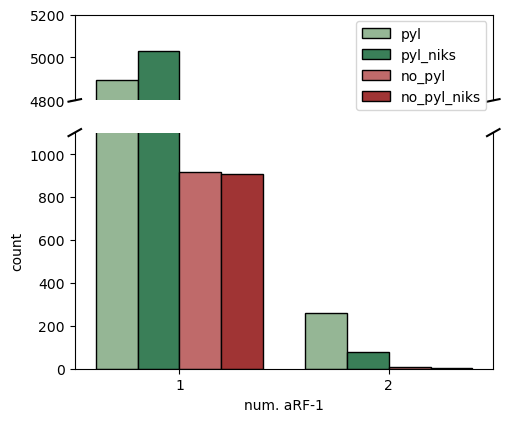

In [ ]:
fig, (ax_top, ax_bottom) = get_split_figure((0, 1100), (4800, 5200))

# figure_df = pd.DataFrame(index=pd.Series(np.arange(1, 4), name='num_arf1'))
figure_df = list()
categories = ['pyl', 'pyl_niks', 'no_pyl', 'no_pyl_niks']
masks = [(arf1_df.has_pyl), (arf1_df.has_pyl & arf1_df.has_niks_domain), (~arf1_df.has_pyl), (~arf1_df.has_pyl & arf1_df.has_niks_domain)]
palette = {'pyl':'darkseagreen', 'pyl_niks':'seagreen', 'no_pyl':'indianred', 'no_pyl_niks':'firebrick'}

for category, mask in zip(categories, masks):
    num_arf1_counts = arf1_df[mask].groupby('genome_id').size().value_counts()
    figure_df += [{'num_arf1':n, 'count':num_arf1_counts.loc[n], 'category':category} for n in num_arf_counts.index]
figure_df = pd.DataFrame(figure_df)
figure_df = figure_df[figure_df.num_arf1 < 4].copy()

# How many cases of Pyl-containing organisms with two ARF-1s and only one with a NIKS domain?
num_arf1_counts = arf1_df[arf1_df.has_pyl].groupby('genome_id').size()
genome_ids_multiple_arf1s = num_arf1_counts[num_arf1_counts > 1].index.values

num_arf1_counts = arf1_df[arf1_df.has_niks_domain & arf1_df.genome_id.isin(genome_ids_multiple_arf1s)].groupby('genome_id').size()
genome_ids_multiple_arf1s_and_one_arf1_with_niks = num_arf1_counts[num_arf1_counts == 1].index.values
genome_ids_multiple_arf1s_with_niks = num_arf1_counts[num_arf1_counts > 1].index.values

print(len(genome_ids_multiple_arf1s))
print(len(genome_ids_multiple_arf1s_and_one_arf1_with_niks))
print(len(genome_ids_multiple_arf1s_with_niks))

sns.barplot(figure_df, x='num_arf1', y='count', hue='category', edgecolor='black', ax=ax_top, palette=palette) #, binsize=0.2)
sns.barplot(figure_df, x='num_arf1', y='count', hue='category', edgecolor='black', ax=ax_bottom, legend=False, palette=palette) #, binsize=0.2)
ax_top.set_ylabel('')
ax_top.get_legend().set_title('')
ax_bottom.set_xlabel('num. aRF-1')
plt.show()

# NIKS is asparagine, isoleucine, lysine, and serine. 


In [ ]:
df = arf1_df[~arf1_df.has_niks_domain].copy()
arf1_df.has_ycf_domain.sum()
arf1_df.has_niks_domain.sum()

np.int64(6109)

In [ ]:
recoded_genome_ids = table_5_metadata_df[table_5_metadata_df['Category 1'] > 50].index.unique()
arf1_df[arf1_df.genome_id.isin(recoded_genome_ids)]

In [ ]:
arf1_df = get_arf1_data(hmmer_df, genome_ids=no_pyl_genome_ids)
arf1_df['length'] = arf1_df.seq.apply(len)
arf1_df['partial'] = ~arf1_df.description.str.contains('partial=00')

arf1_df = arf1_df[(arf1_df.length < 600) & (arf1_df.length > 300)].copy()
arf1_df = arf1_df[~arf1_df.partial].copy()
arf1_df = arf1_df[arf1_df.seq.str.contains('GGQ')].copy() # Make sure the release factors have the catalytic domain.
arf1_df = arf1_df[arf1_df.seq.str.contains('NIK[ST]', regex=True)].copy() # Make sure the release factors have the NIKS domain.

def get_niks_region(seq:str, window_size:int=50):
    pattern = r'NIK[ST]'
    match_ = re.search(pattern, seq)

    start = max(0, match_.start() - window_size)
    stop = max(0, match_.end() + window_size)
    return seq[start:stop]

arf1_df['seq'] = arf1_df.seq.apply(get_niks_region)

FASTAFile.from_df(arf1_df).write('../data/arf1_no_pyl.fa')
# ! mmseqs easy-cluster '../data/arf1_no_pyl.fa' '../data/arf1_no_pyl' '../data/tmp' --min-seq-id 0.90
# arf1_cluster_df = pd.read_csv('../data/arf1_no_pyl_cluster.tsv', sep='\t', names=['rep_id', 'id'])
# print('Num. clusters:', arf1_cluster_df.rep_id.nunique(), end='\n\n')

In [ ]:

dayhoff6 = {aa: grp for grp, aas in zip('abcdef', [['C'], ['A','G','P','S','T'], ['D','E','N','Q'], ['H','K','R'], ['I','L','M','V'], ['F','W','Y']]) for aa in aas}
reduced12 = {'A':'A','G':'A','S':'A','T':'A','P':'P','C':'C','D':'D','E':'D','N':'D','Q':'D','H':'H','K':'H','R':'H','I':'I','L':'I','M':'I','V':'I','F':'F','Y':'F','W':'F'}

def load_alignment(path:str=f'../data/arf1_no_pyl.afa', alphabet=dayhoff6):
    df = FASTAFile().from_fasta(path).to_df()
    index = df.index.values
    alignment = [list(seq) for seq in df.seq]

    if alphabet is not None:
        alignment = [[alphabet.get(aa, '-') for aa in row] for row in alignment]

    return index, np.array(alignment)

index, alignment = load_alignment(alphabet=reduced12)

Num. completely conserved residues: 7


Text(0.5, 1.0, 'aRF-1')

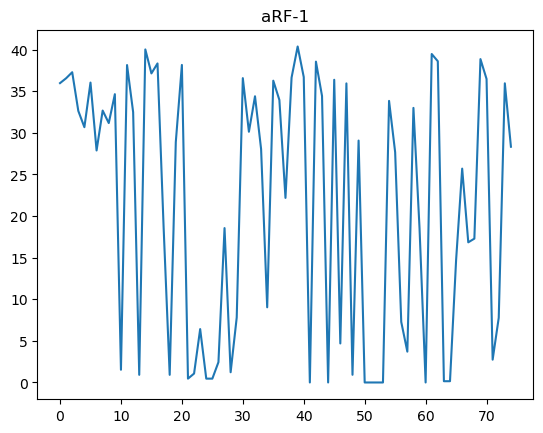

In [ ]:

fig, ax = plt.subplots()

alignment = alignment[:, :75] # There's a gap in the alignment after 75. 

# domains = ['NIK[ST]', 'Y.C...F', 'GGQ']
domains = ['NIK[ST]']

conserved = [np.all(column == column[0]) for column in alignment.T]
print('Num. completely conserved residues:', sum(conserved))

probabilities = [[(column == aa).mean() for aa in column] for column in alignment.T]
scores = [-sum([p_ * math.log(p_, len(p)) for p_ in p]) for p in probabilities]

sns.lineplot(x=np.arange(len(scores)), y=scores)
# for i in np.where(scores > 0.2)[0]:
#     ax.axvline(i, lw=0.7)
#     ax.text(i, ax.get_ylim()[-1], str(i), va='bottom', ha='center', rotation=90, color='tab:blue', fontsize='x-small')

ax.set_title('aRF-1')

In [ ]:
# Key questions: 

# Are there any residues in the catalytically-active aRF-1 proteins in Pyl-utilizing archaea which are not present
# in any of the non-Pyl-utilizing archaea? Specifically looking around the NIKS binding site, and perhaps 
# with a specific focus on the organisms which seem to be largely re-coded (lots of category 1 genes).



[np.float64(6.481310409649298),
 np.float64(6.29263883788508),
 np.float64(6.4932658543986985),
 np.float64(6.372025554537446),
 np.float64(6.22645411231643),
 np.float64(6.303011884517069),
 np.float64(6.426020846857387),
 np.float64(6.344662212151171),
 np.float64(6.3947455043804915),
 np.float64(6.346941214470044),
 np.float64(6.551912437978128),
 np.float64(6.393212024840663),
 np.float64(6.264282049587911),
 np.float64(6.501179287109888),
 np.float64(6.419470277608128),
 np.float64(6.360044291376092),
 np.float64(6.43514851490262),
 np.float64(6.457357078126387),
 np.float64(6.53030570155558),
 np.float64(6.314213354260083),
 np.float64(6.5324914016971665),
 np.float64(6.605405148613498),
 np.float64(6.544484369300507),
 np.float64(6.5557162849984625),
 np.float64(6.599913640568812),
 np.float64(6.578116651278961),
 np.float64(6.477079686068558),
 np.float64(6.466887269598035),
 np.float64(6.554388738858357),
 np.float64(6.551312599482912),
 np.float64(6.447119902534888),
 np.floa

In [ ]:
''.join((alignment[np.where(groups == False)[0]][:, 36]))

# The N domain is responsible for stop codon recognition. Motifs include TASNIKS and YxCxxxF

'TDSDTD'

In [ ]:
''.join((alignment[np.where(groups == True)[0]][:, 36]))

'TTDTTTTTDTTTTTTTTTNTTT'

In [ ]:
FASTAFile('../data/ncbi/genomes/GCA_002505325.1.fn').to_df()
# ~/muscle5.1.linux_intel64 -align arf1.fa -output arf1.afa ous 

,description,seq
id,,
DAUV01000075.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,GATCAACGTGTTTACGTCGAGGGTCAAGAGGCTCTGGCAGTTTCTG...
DAUV01000089.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,GGAACGGAGGCTCTCAGCGTGGCGGATCGGCAGGATATAGTGAGCT...
DAUV01000031.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,CGAGCTCTCCAAGGCGGTCGCAGATATCATCGCCAGTGAGGTCAAC...
DAUV01000057.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,TCCGCGGCGTCCTCGGCCTCCTTACGGCGTCGCAGAATCTCAGGAC...
DAUV01000047.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,CCAAAAGAACAGCAGCGGGCGTGGCGCGTTGCGCGACCTCAGGGTG...
...,...,...
DAUV01000014.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,ACTTCGCATATGCTCAAAATGCAAAGGAGAATCATACAGAAGCCGG...
DAUV01000039.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,GAACCTGTCATCGGCCTGTGGTCCCGGGTCGACGGACATTCTCTTG...
DAUV01000081.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,GCTGTGAAATACGCAGACCTTTCTACAGAGAGGACGAAGGACTACG...
